In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import pandas as pd
import os
import collections
import math 

from loguru import logger
from sklearn import preprocessing
from scipy.stats import ttest_ind

from collections import defaultdict

## Some useful methods

The main method to run experiments

In [4]:
def calc_av_p_scores(sample_fnames, data_names, condition_1, condition_2, num_iterations, percent=None, random=False, noise_std=5):
    for it in range(num_iterations):
        
        # constructs the fold-change dataframe, adding random peaks if necessary
        fc_df = construct_fc_df(sample_fnames, data_names, random) 
        
        if percent is not None: # have random peaks
            add_random_df = add_random_peaks(sample_fnames, fc_df, percent, noise_std)
            pathway_acts = get_pathway_act(add_random_df, data_names)
            
        else: # no random peaks
            pathway_acts = get_pathway_act(fc_df, data_names)
            
        # calculate the t-test results, if it is the first iteration, initialise the df.
        if it == 0:   
            t_results = get_t_test(pathway_acts, condition_1, condition_2).sort_index(axis=0)      
        else:  
            t_results = t_results + get_t_test(pathway_acts, condition_1, condition_2).sort_index(axis=0)      

    # get the average results
    final = t_results/num_iterations
    new_df = final.sort_values(by='EA_Score', ascending = True)
    return new_df

Constructs the fold-change dataframe

In [5]:
def construct_fc_df(sample_fnames, data_names, random=False):
    if not random: # use predetermined data
        data = [12.0, 12.0, 6.0, 6.0, -7.0, -7.0, -17.0, -17.0]
    else: # randomly sample from a normal distribution
        data = data = np.random.normal(0, 1, 8)    
    
    # loop over pathway names, generate logged peak data (with some noise) up to num peaks
    pk_samp_intensities = []
    for name, num in data_names.items():
        for n in range(num):
                peak_int_list =[]
                peak_int_list.append(name) 
                data_noise = data + np.random.normal(0, 5, len(data))
                peak_int_list.extend(list(data_noise)) # The intensities of all the samples for this peak.
                pk_samp_intensities.append(peak_int_list)

    fc_df = pd.DataFrame(pk_samp_intensities).set_index([0])
    fc_df.columns=sample_fnames
    fc_df.index.name = "ms1_peak_id"
    fc_df.columns.name ="sample_name"

    scaled_data = preprocessing.scale(np.array(fc_df), axis=1)
    fc_df[sample_fnames] = scaled_data
    return fc_df

Adds a percentage of random peaks to a peak intensity df

In [6]:
def add_random_peaks(sample_fnames, int_df, percent, noise_std):
    if percent == 0:
        new_df = int_df.copy()
        scaled_data = preprocessing.scale(np.array(new_df), axis=1)
        new_df[sample_fnames] = scaled_data
        return new_df
    else:
        #For each of the pathways add random peaks
        rand_peak_list = []   
        for name in data_names:
            # get all peak intensities in that pathway
            df_path = int_df.loc[name]

            # compute percentage of random peaks to add
            num_peaks = math.ceil((df_path.shape[0])*(percent/100.0))
            num_samples = df_path.shape[1]

            # generate random peaks for that pathway
            for p in range(int(num_peaks)):
                rand_peaks = []
                data = np.random.normal(0, noise_std, num_samples)
                rand_peaks.append(name)
                rand_peaks.extend(list(data))
                rand_peak_list.append(rand_peaks)

        # construct a DF for the new peak list
        ran_df = pd.DataFrame(rand_peak_list).set_index([0])
        ran_df.columns = sample_fnames

        # add the random peaks to the original DF
        new_df = pd.concat([int_df, ran_df])
        scaled_data = preprocessing.scale(np.array(new_df), axis=1)
        new_df[sample_fnames] = scaled_data
        return new_df

Returns the peak activities given a peak DF composed of pathways

In [7]:
def get_pathway_act(int_df, data_names):
    #For all of the pathways get all of the peak IDs
    pathway_activities = []
    
    for name in data_names:
        pathway_peaks = int_df.loc[name] #DF selected from peak IDs.
        w, d, c = np.linalg.svd(np.array(pathway_peaks))
        pw_act_list = []
        pw_act_list.append(name)
        pw_act_list.extend(list(c[0]))
        pathway_activities.append(pw_act_list)
        
        activity_df = pd.DataFrame(pathway_activities).set_index([0])
        activity_df.columns=int_df.columns
        activity_df.index.name = "Pathways"
    return activity_df

Returns p-value and t-test for an activity DF

In [8]:
def get_t_test(noisy_df, condition_1, condition_2):
    t_test_list = []

    for pathway, row in noisy_df.iterrows():
        c1 = noisy_df.loc[pathway, condition_1].values
        c2 = noisy_df.loc[pathway, condition_2].values
        path_params = [pathway] + list(ttest_ind(c1,c2))
        t_test_list.append(path_params)

    t_test_df = pd.DataFrame(t_test_list).set_index([0])
    t_test_df.columns = ['t-stat', 'EA_Score']
    t_test_df = t_test_df.sort_values(by='EA_Score', ascending = True)
    return t_test_df

## Heat map of intensity matrix

In [9]:
sample_fnames = [u'Control_4.mzXML', u'Control_3.mzXML', u'Control_2.mzXML', 
           u'Control_1.mzXML', u'Neg_fold_1.mzXML', u'Neg_fold_2.mzXML', u'Neg_fold_3.mzXML', u'Neg_fold_4.mzXML']

data_names ={"two":2, "four":4, "six":6, "ten":10, "twenty":20, "forty":40, "eighty":80}

In [10]:
fc_df = construct_fc_df(sample_fnames, data_names, random=False)

In [11]:
fc_df

sample_name,Control_4.mzXML,Control_3.mzXML,Control_2.mzXML,Control_1.mzXML,Neg_fold_1.mzXML,Neg_fold_2.mzXML,Neg_fold_3.mzXML,Neg_fold_4.mzXML
ms1_peak_id,,,,,,,,
two,0.569845,1.078947,0.612547,1.019860,-0.386744,0.183412,-1.242302,-1.835565
two,1.379031,1.493090,0.648713,0.138804,-0.790999,-0.757913,-1.079581,-1.031143
four,1.486060,1.447186,0.494506,0.037038,-0.669972,-0.457226,-1.343842,-0.993751
four,1.655428,0.762757,0.476096,0.482947,-1.085368,0.121472,-1.444351,-0.968981
four,0.751255,1.000387,0.946984,0.672820,-0.265461,-0.791078,-2.082036,-0.232870
...,...,...,...,...,...,...,...,...
eighty,1.703484,0.850885,0.405769,0.430853,-0.159501,-0.493480,-1.311808,-1.426202
eighty,0.887737,1.070356,0.821571,0.705695,0.107630,-0.627215,-1.695475,-1.270299
eighty,1.697462,0.879387,0.571849,0.558447,-0.583839,-1.021905,-0.812653,-1.288746


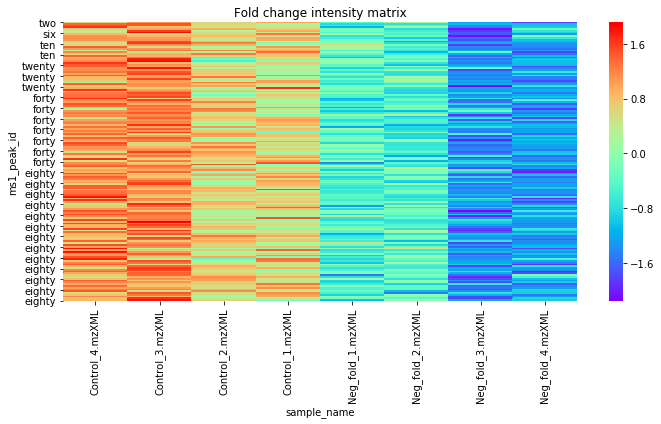

In [12]:
import seaborn as sns; 
plt.figure(figsize=(10, 6))
sns.heatmap(fc_df, cmap="rainbow")
plt.title("Fold change intensity matrix")
plt.tight_layout()
plt.savefig("fold_change.png", dpi=300)

### Check EA-scores as we add more noisy peaks

In [13]:
def construct_single_box_df(df, random_peaks):
    columns = ['Pathway', "Random_peaks", "EA_Score"]
    box_plot_df = pd.DataFrame(columns=columns)
    box_plot_df.Pathway = list(df.index)
    box_plot_df.Random_peaks=float(random_peaks)
    box_plot_df.EA_Score = df.EA_Score.values
    return box_plot_df

In [14]:
condition_1 = [u'Control_4.mzXML', u'Control_3.mzXML', u'Control_2.mzXML', u'Control_1.mzXML']

condition_2 = [u'Neg_fold_1.mzXML', u'Neg_fold_2.mzXML', u'Neg_fold_3.mzXML', u'Neg_fold_4.mzXML']

NUM_ITERATIONS = 100
random = False # whether to sample intensity data randomly or using pre-set values

reqd_scenarios = [
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 0 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 50 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 100 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 200 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 300 },
    { 'num_iterations': NUM_ITERATIONS, 'random': random, 'noise_std': 5, 'percent': 1000 },
]

In [15]:
columns = ['Pathway', "Random_peaks", "EA_Score"]
box_plot_df = pd.DataFrame(columns=columns)
for scenario in reqd_scenarios:
    logger.info(scenario)
    df = calc_av_p_scores(sample_fnames, data_names, condition_1, condition_2, NUM_ITERATIONS, 
                          percent=scenario['percent'], random=scenario['random'], noise_std=scenario['noise_std'])
    single_box_df = construct_single_box_df(df, scenario['percent'])        
    box_plot_df = box_plot_df.append(single_box_df, ignore_index=True)

2019-12-16 17:03:12.844 | INFO     | __main__:<module>:4 - {'num_iterations': 100, 'random': False, 'noise_std': 5, 'percent': 0}
2019-12-16 17:03:14.907 | INFO     | __main__:<module>:4 - {'num_iterations': 100, 'random': False, 'noise_std': 5, 'percent': 50}
2019-12-16 17:03:17.735 | INFO     | __main__:<module>:4 - {'num_iterations': 100, 'random': False, 'noise_std': 5, 'percent': 100}
2019-12-16 17:03:20.631 | INFO     | __main__:<module>:4 - {'num_iterations': 100, 'random': False, 'noise_std': 5, 'percent': 200}
2019-12-16 17:03:23.865 | INFO     | __main__:<module>:4 - {'num_iterations': 100, 'random': False, 'noise_std': 5, 'percent': 300}
2019-12-16 17:03:27.446 | INFO     | __main__:<module>:4 - {'num_iterations': 100, 'random': False, 'noise_std': 5, 'percent': 1000}


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


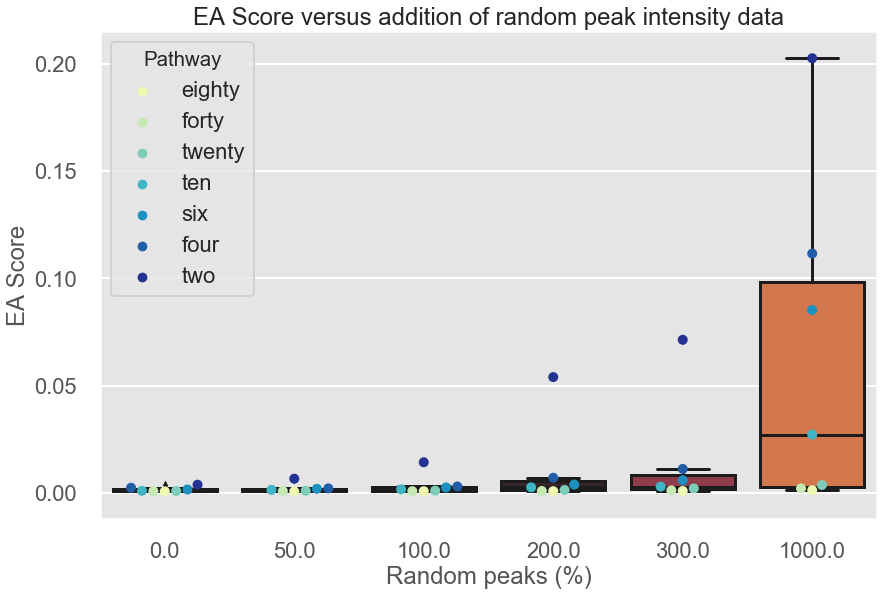

In [16]:
style.use('seaborn-poster') #sets the size of the charts
sns.set(style="whitegrid")
style.use('ggplot')
sns.set_context('poster')  #Everything is larger

ax = sns.boxplot(x="Random_peaks", y="EA_Score", data=box_plot_df, palette=("icefire"))
ax = sns.swarmplot(x="Random_peaks", y="EA_Score", hue="Pathway", data=box_plot_df, size=10, palette=("YlGnBu"))
ax.set(xlabel='Random peaks (%)', ylabel='EA Score')
plt.title("EA Score versus addition of random peak intensity data")
plt.tight_layout()
plt.savefig("box_plot.eps", dpi=300)

## Plot EA score changes as we add more random peaks at varying noise level

In [17]:
def get_combined_df(percents, noise_std, num_iterations):
    dfs = []
    for percent in percents:
        logger.info('percent=%.2f noise_std=%.1f' % (percent, noise_std))
        df = calc_av_p_scores(sample_fnames, data_names, condition_1, condition_2, num_iterations=num_iterations, percent=percent, noise_std=noise_std)
        df['percent'] = percent
        df['noise_std'] = noise_std
        dfs.append(df)

    combined_df = pd.concat(dfs)
    combined_df.index.name = 'pathway'
    combined_df.head()
    return combined_df

### Noise std deviation = 5

In [18]:
percents = [0, 50, 100, 200, 300, 1000]
noise_std = 5
combined_df = get_combined_df(percents, noise_std, NUM_ITERATIONS)

2019-12-16 17:03:33.545 | INFO     | __main__:get_combined_df:4 - percent=0.00 noise_std=5.0
2019-12-16 17:03:35.521 | INFO     | __main__:get_combined_df:4 - percent=50.00 noise_std=5.0
2019-12-16 17:03:38.226 | INFO     | __main__:get_combined_df:4 - percent=100.00 noise_std=5.0
2019-12-16 17:03:41.070 | INFO     | __main__:get_combined_df:4 - percent=200.00 noise_std=5.0
2019-12-16 17:03:44.150 | INFO     | __main__:get_combined_df:4 - percent=300.00 noise_std=5.0
2019-12-16 17:03:47.456 | INFO     | __main__:get_combined_df:4 - percent=1000.00 noise_std=5.0


Text(0.5, 1.0, 'The effect of adding random peaks to EA score (noise_std=5)')

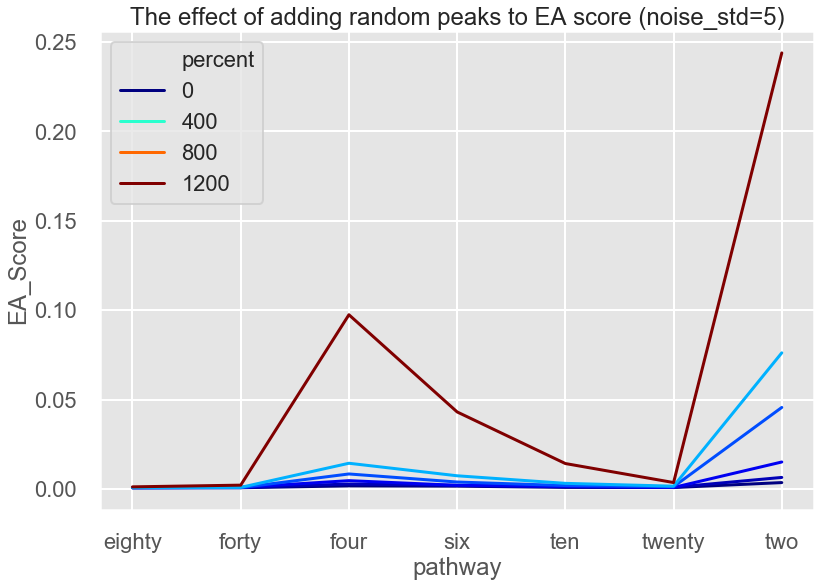

In [19]:
sns.lineplot(x=combined_df.index, y='EA_Score', hue='percent', data=combined_df, palette=("jet"))
plt.title('The effect of adding random peaks to EA score (noise_std=%d)' % noise_std)

### Noise std deviation = 1

In [20]:
percents = [0, 50, 100, 200, 300, 1000]
noise_std = 1
combined_df = get_combined_df(percents, noise_std, NUM_ITERATIONS)

2019-12-16 17:03:53.353 | INFO     | __main__:get_combined_df:4 - percent=0.00 noise_std=1.0
2019-12-16 17:03:55.497 | INFO     | __main__:get_combined_df:4 - percent=50.00 noise_std=1.0
2019-12-16 17:03:58.280 | INFO     | __main__:get_combined_df:4 - percent=100.00 noise_std=1.0
2019-12-16 17:04:01.251 | INFO     | __main__:get_combined_df:4 - percent=200.00 noise_std=1.0
2019-12-16 17:04:04.498 | INFO     | __main__:get_combined_df:4 - percent=300.00 noise_std=1.0
2019-12-16 17:04:07.778 | INFO     | __main__:get_combined_df:4 - percent=1000.00 noise_std=1.0


Text(0.5, 1.0, 'The effect of adding random peaks to EA score (noise_std=1)')

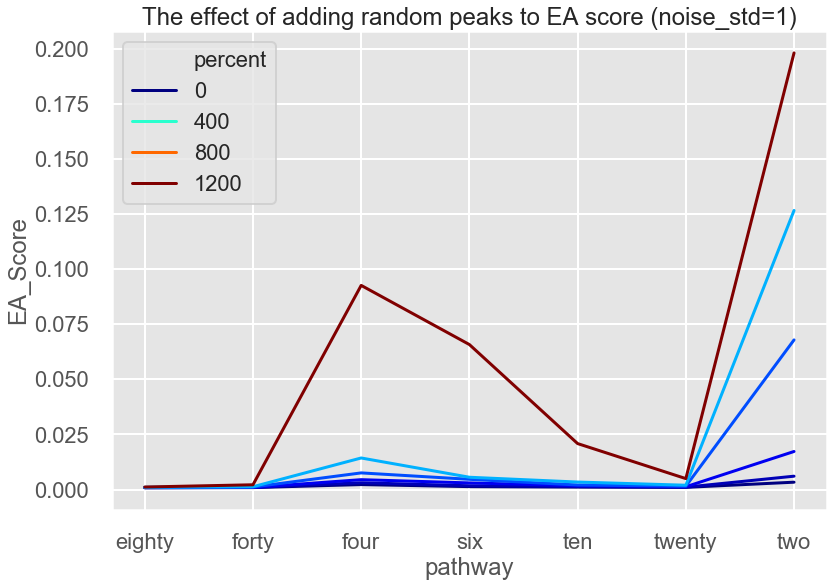

In [21]:
sns.lineplot(x=combined_df.index, y='EA_Score', hue='percent', data=combined_df, palette=("jet"))
plt.title('The effect of adding random peaks to EA score (noise_std=%d)' % noise_std)

### Nothing is changing, it's all random

In [22]:
all_random = calc_av_p_scores(sample_fnames, data_names, condition_1, condition_2, num_iterations=NUM_ITERATIONS, random=True)
all_random

,t-stat,EA_Score
0,,
six,-0.207711,0.480226
four,-0.103658,0.506610
twenty,-0.059229,0.512696
eighty,0.029131,0.529942
ten,-0.077567,0.544137
two,0.066146,0.547257
forty,-0.070207,0.575594
